# Проект: классификация

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [45]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [46]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [47]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [48]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace({'\$':''}, regex=True)# используем параметр regex=True, чтобы указать, что мы хотим заменить символ $ в 
# столбце 'Text'. Если этот параметр не указан или имеет значение False, replace() будет искать точное совпадение символов для замены. 
df['balance'] = df['balance'].replace({',00':''}, regex=True)
df['balance'] = df['balance'].replace({' ':''}, regex=True)
df['balance'] = df['balance'].astype('float64')

### Задание 4

In [49]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
median = df.balance.median()
df.balance = df.balance.fillna(median)

### Задание 5

In [50]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_education = df.education.mode()[0]
mode_job = df.job.mode()[0]

df['job'] = df['job'].apply(lambda x: mode_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: mode_education if x == 'unknown' else x)


In [51]:
popular_job_education = df[(df['job'] == mode_job) & (df['education'] == mode_education)]
round(popular_job_education['balance'].mean(),3)

1598.883

### Задание 6

In [52]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature,log_scale=False,left = 1.5, right = 1.5):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')
print('Нижняя граница {}'.format(lower_bound))
print('Верхняя граница {}'.format(upper_bound))
print('Размер выборки {}'.format(cleaned.shape))

Нижняя граница -2241.0
Верхняя граница 4063.0
Размер выборки (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

In [53]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
px.bar(cleaned.deposit.value_counts().round(2), text_auto=True, title='Share of participation',color=cleaned.deposit.value_counts(True))


### Задания 2 и 3

In [54]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
print(cleaned['duration'].describe())
print('\t')
print(cleaned['duration'].describe())

count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64
	
count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64


### Задания 4 и 5

In [55]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
fig = px.bar(cleaned['month'].value_counts(),color=cleaned.month.value_counts(True),title= 'month when be company')
fig.show()
fig_1= px.bar(cleaned['job'].value_counts(),color=cleaned.job.value_counts(True), title= 'types of work')
fig_1.show()

### Задание 6

In [56]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
fig_2 = px.bar(cleaned.poutcome.value_counts(),color=cleaned.poutcome.value_counts(True),title ='result of the last marketing campaign')
fig_2.show()

### Задание 7

In [57]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month_and_poutcome = cleaned.groupby(['poutcome','month']).size().reset_index(name='count')
fig_3 = px.bar(month_and_poutcome, x="month",y="count", color="poutcome",
             pattern_shape="poutcome",pattern_shape_sequence=[".", "x", "+", "-"], title='the dependence of the month and the success of the company')
fig_3.show()

In [58]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


### Задание 8

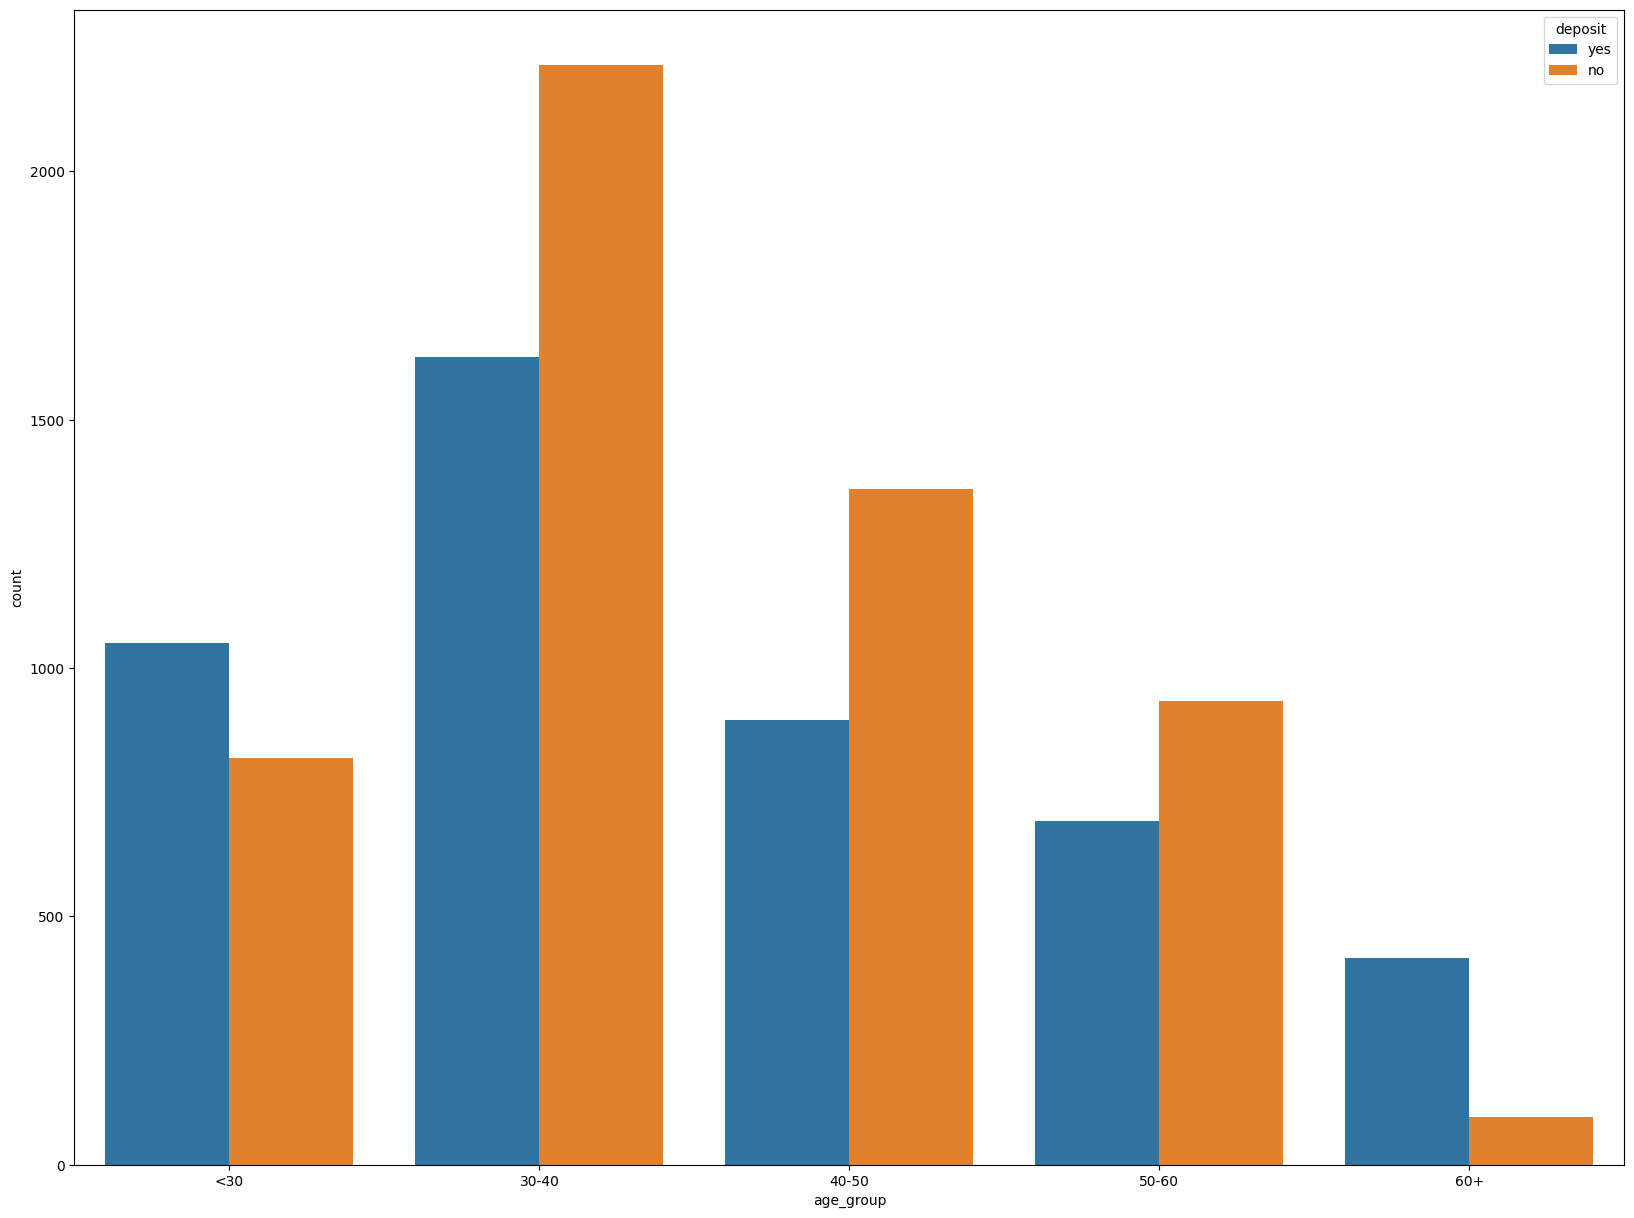

In [59]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
'''def category_age(x):
    if x < 30:
        return 'befor_29'
    elif 30 <= x < 40 :
        return 'between_30_39'
    elif 40 <= x < 50 :
        return 'between_40_49'
    elif 50 <= x < 60 :
        return 'between_50_59'
    elif 60 <= x :
        return 'after_60'
cleaned['age'] = cleaned.age.apply(category_age)'''
# Для создания категорий используем метод cut()

cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
cleaned = cleaned.drop(['age'],axis=1)
sns.countplot(x="age_group", hue="deposit", data=cleaned);

### Задания 9 и 10

In [60]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
deposit_and_marital = cleaned.groupby(['marital','deposit']).size().reset_index(name='count')

fig_marital_and_deposit = px.bar(deposit_and_marital, x='marital', y='count', color='deposit',pattern_shape="deposit",
                                pattern_shape_sequence=["x", "+"],title='who have opened and not opened a deposit, depending on the family status')
fig_marital_and_deposit.show()

In [61]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
deposit_and_education = cleaned.groupby(['deposit','education']).size().reset_index(name='count')

fig_deposit_and_education = px.bar(deposit_and_education, x='education', y='count', color='deposit',pattern_shape="deposit",
                                pattern_shape_sequence=["x", "+"],title='who have opened and not opened a deposit, depending on the education')
fig_deposit_and_education.show()

In [62]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
deposit_and_job = cleaned.groupby(['deposit','job']).size().reset_index(name='count')

fig_job_and_deposit = px.bar(deposit_and_job, x='job', y='count', color='deposit',pattern_shape="deposit",
                            pattern_shape_sequence=["x", "+"],
                            title='who have opened and not opened a deposit, depending on the job')
fig_job_and_deposit.show()

### Задание 11

In [63]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposit_yes = cleaned[cleaned['deposit'] == 'yes']

fig = px.density_heatmap(df_deposit_yes, x="education", y="marital", marginal_y="histogram",
                         title='heat map of the categories education and marital status, who agreed to open a deposit')
fig.show()

df_deposit_no = cleaned[cleaned['deposit'] == 'no']

fig = px.density_heatmap(df_deposit_no, x="education", y="marital", marginal_y="histogram",
                         title='heat map of the education and marital status categories that did not agree to open a deposit')
fig.show()

## Часть 3: преобразование данных

### Задание 1

In [64]:
# преобразуйте уровни образования
lab_enc = LabelEncoder()

# Кодирование признака
cleaned['education'] = lab_enc.fit_transform(cleaned['education'])

cleaned['age_group'] = lab_enc.fit_transform(cleaned['age_group'])

### Задания 2 и 3

In [65]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned.default = cleaned.default.apply(lambda x: 1 if x == 'yes' else 0)
cleaned.housing = cleaned.housing.apply(lambda x: 1 if x == 'yes' else 0)
cleaned.loan = cleaned.loan.apply(lambda x: 1 if x == 'yes' else 0)
cleaned.deposit = cleaned.deposit.apply(lambda x: 1 if x == 'yes' else 0)

### Задание 4

In [66]:
cleaned = pd.get_dummies(cleaned)
cleaned.head()

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,2343.0,1,0,5,1042,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,45.0,0,0,5,1467,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,0,1270.0,1,0,5,1389,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,2476.0,1,0,5,579,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,2,0,184.0,0,0,5,673,2,-1,0,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

In [67]:
# Матрица корреляции
round(cleaned.corr(),1)

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
education,1.0,-0.0,0.0,-0.1,-0.1,0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.1,-0.1,0.0,0.0,0.0,0.0,0.0,0.1,-0.1
default,-0.0,1.0,-0.1,0.0,0.1,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1
balance,0.0,-0.1,1.0,-0.1,-0.1,-0.0,0.0,-0.0,0.0,0.1,...,0.0,0.0,-0.1,0.1,0.1,0.0,0.0,0.0,0.1,-0.1
housing,-0.1,0.0,-0.1,1.0,0.1,-0.0,0.0,0.0,0.1,-0.0,...,-0.1,-0.1,0.4,-0.0,-0.1,-0.1,0.1,0.0,-0.1,0.0
loan,-0.1,0.1,-0.1,0.1,1.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.1,0.1
day,0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.1,-0.1,-0.1,...,-0.2,-0.0,-0.0,0.1,0.1,-0.1,-0.1,-0.0,-0.0,0.1
duration,-0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1
campaign,-0.0,0.0,-0.0,0.0,0.0,0.1,-0.0,1.0,-0.1,-0.1,...,0.0,-0.0,-0.0,-0.1,-0.1,-0.0,-0.1,-0.0,-0.1,0.1
pdays,0.0,-0.0,0.0,0.1,-0.0,-0.1,-0.0,-0.1,1.0,0.5,...,-0.1,0.0,0.0,-0.0,0.1,0.1,0.6,0.3,0.3,-0.8
previous,0.0,-0.0,0.1,-0.0,-0.0,-0.1,-0.0,-0.1,0.5,1.0,...,-0.1,0.0,-0.0,0.0,0.1,0.1,0.3,0.3,0.3,-0.6


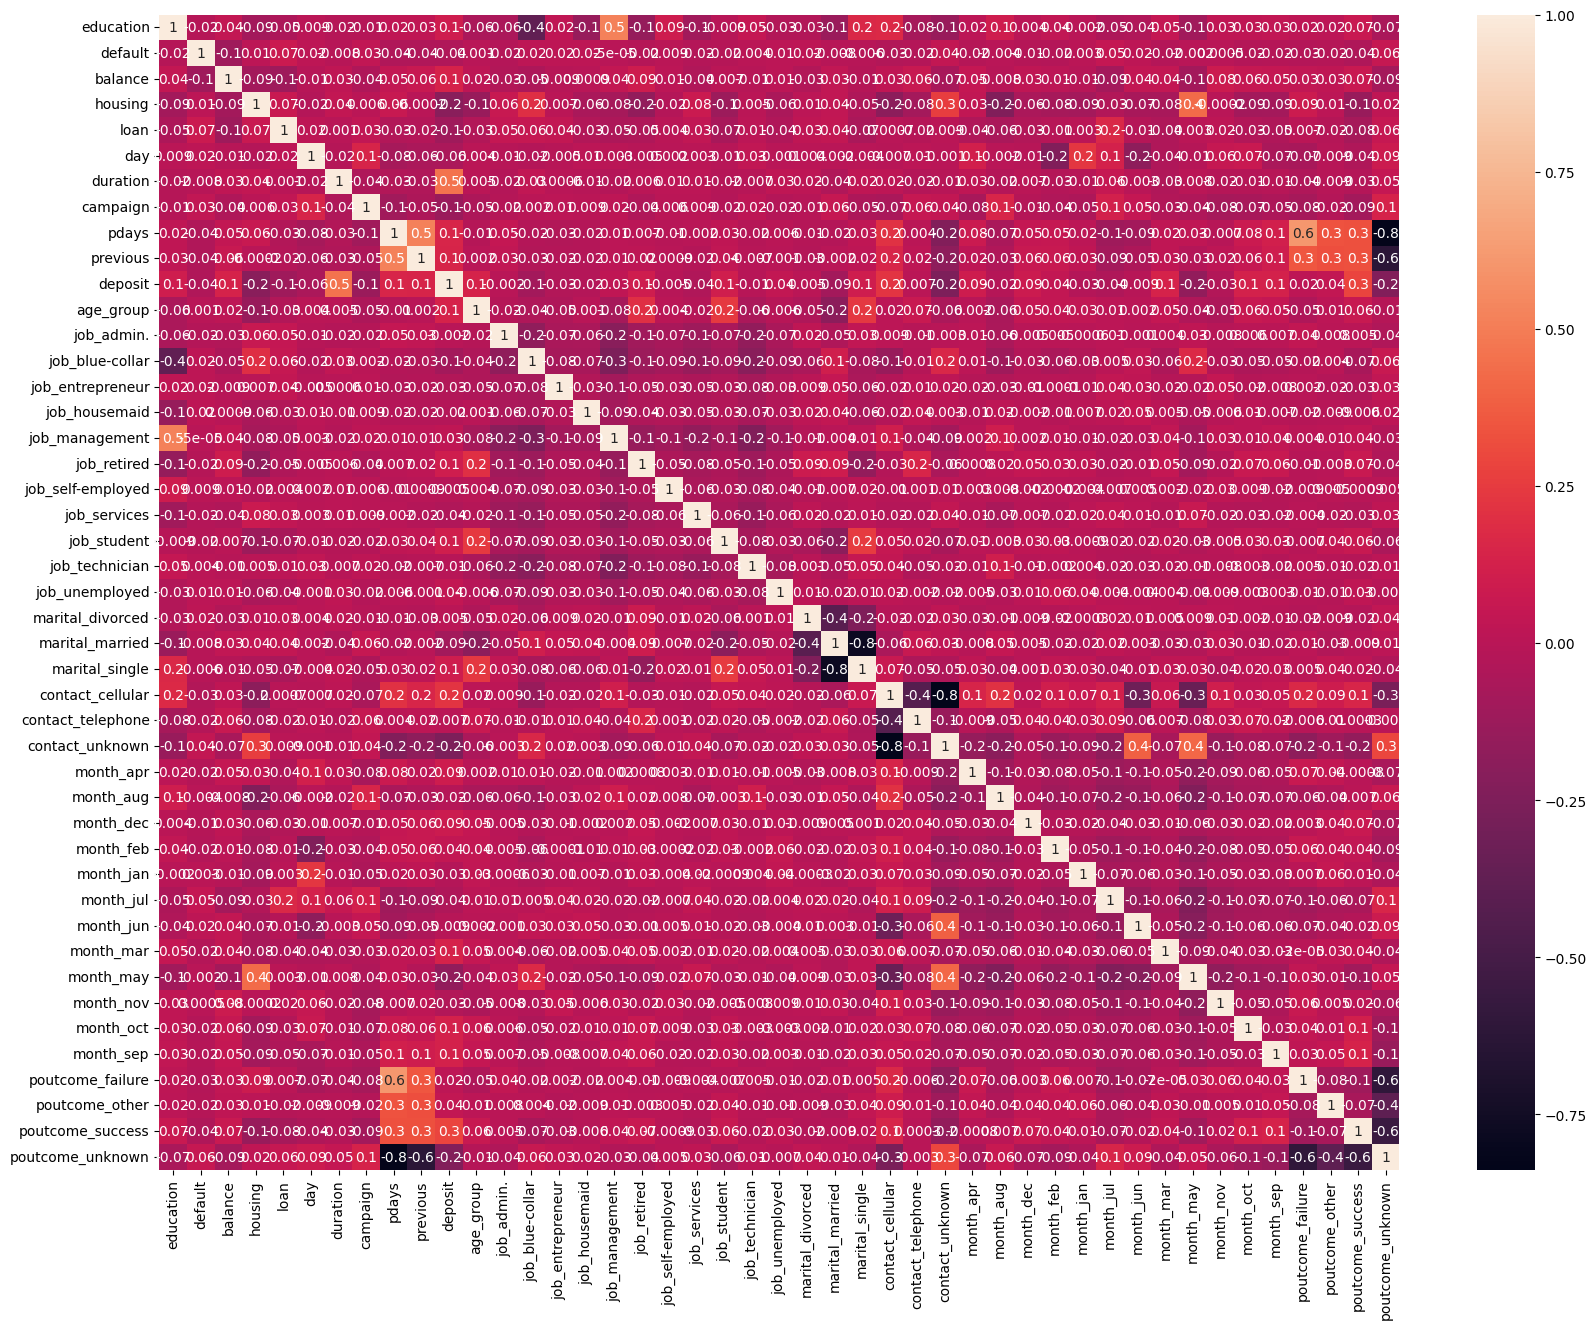

In [68]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(cleaned.corr(),annot= True, fmt='.1g');
# Хоть и таблица большая, и объекты, чья корреляция близка к нулю, смываются с другими схожими объектами, но ключевые объекты отлично
# и разборчиво видны

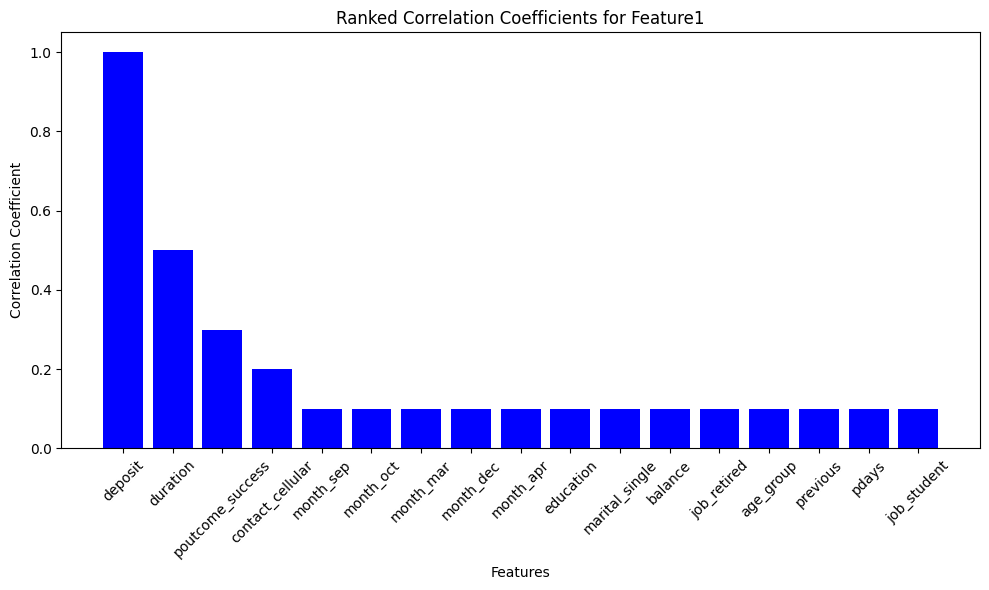

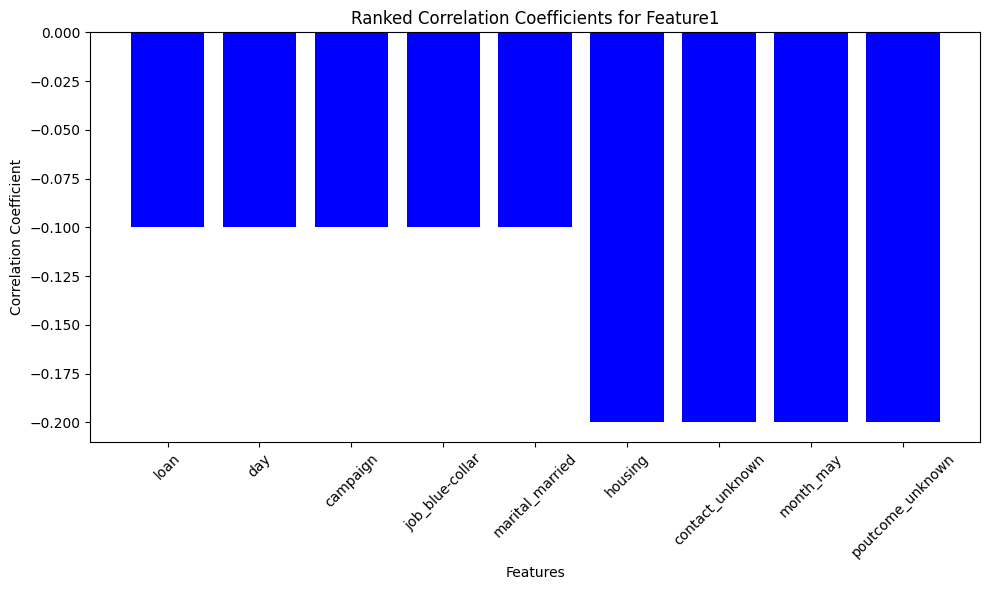

In [69]:

# Выбираем строку или столбец с коэффициентами корреляции для интересующей вас переменной
corr_values = round(cleaned.corr(),1)['deposit']  # Или correlation_matrix_df.loc['Feature1']

# Фильтруем только положительные значения
positive_corr_values = corr_values[corr_values > 0]

# Сортируем значения
sorted_corr_values = positive_corr_values.sort_values(ascending=False)

# Создаем столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(sorted_corr_values.index, sorted_corr_values.values, color='blue')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Ranked Correlation Coefficients for Feature1')
plt.xticks(rotation=45)
plt.tight_layout()

# Отображаем диаграмму
plt.show()

# Фильтруем только отрицательные значения
negative_corr_values = corr_values[corr_values < 0]

# Сортируем значения
sorted_corr_values = negative_corr_values.sort_values(ascending=False)

# Создаем столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(sorted_corr_values.index, sorted_corr_values.values, color='blue')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Ranked Correlation Coefficients for Feature1')
plt.xticks(rotation=45)
plt.tight_layout()

# Отображаем диаграмму
plt.show()

### Задания 7 и 8

In [70]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [71]:
# рассчитайте необходимые показатели
X_test.shape

round(np.mean(y_test),2)

0.46

### Задание 9

In [72]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
select = SelectKBest(f_classif, k=15)
select.fit(X_train,y_train)

select.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [73]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

round((X_test_scaled[:,0].mean()),2)

0.6

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [74]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag',
                                          max_iter=1000,
                                          random_state=42)
log_reg.fit(X_train_scaled,y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [75]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = 42,
    max_depth=6
)
dt.fit(X_train_scaled, y_train)
y_test_pred = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.81      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 5

In [76]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters = {'min_samples_split': [2, 5, 7, 10],'max_depth':[3,5,7]}

gsc = GridSearchCV(
    tree.DecisionTreeClassifier(),
    parameters,
    cv=3,scoring=('f1'), 
    return_train_score=True)

gsc.fit(X_train_scaled, y_train)
y_test_pred = gsc.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [77]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [84]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gbr.fit(X_train_scaled,y_train)

y_test_pred = gbr.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.83      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.86      0.85      3335
weighted avg       0.86      0.85      0.85      3335



### Задание 4

In [85]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stcl = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stcl.fit(X_train_scaled,y_train)

y_test_pred = stcl.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 5

In [88]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
select = SelectKBest(f_classif, k=3)
select.fit(X_train_scaled,y_train)

select.get_feature_names_out()

array(['x6', 'x27', 'x42'], dtype=object)

### Задания 6,7,8

In [97]:
from sklearn import ensemble
from sklearn import metrics
import optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=2)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [98]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)



[I 2023-08-13 14:35:54,519] A new study created in memory with name: RandomForestClassifier
[I 2023-08-13 14:35:55,395] Trial 0 finished with value: 0.8759462382202996 and parameters: {'n_estimators': 128, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8759462382202996.
[I 2023-08-13 14:35:56,767] Trial 1 finished with value: 0.8740946216674371 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8759462382202996.
[I 2023-08-13 14:35:57,793] Trial 2 finished with value: 0.8732134624250807 and parameters: {'n_estimators': 151, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8759462382202996.
[I 2023-08-13 14:35:59,030] Trial 3 finished with value: 0.8993935624319702 and parameters: {'n_estimators': 118, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8993935624319702.
[I 2023-08-13 14:36:00,816] Trial 4 finished with value: 0.904732446643984 and parameters: {'n_

In [99]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.95


In [101]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=2 )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.84
